In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/capstone projects/creditcard.csv')

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify = y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify = y_train, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform='pandas')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

### Model 1 Vanilla ANN

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

In [29]:
def focal_loss(alpha=0.25, gamma=2):
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        pt = K.exp(-bce)
        focal = alpha * (1 - pt) ** gamma * bce
        return K.mean(focal)
    return loss

def create_ann():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss=focal_loss(),
                  metrics=['recall'])

    return model

In [30]:
from sklearn.utils.class_weight import compute_class_weight

class_labels = np.unique(y_train)

class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=y_train)

class_weight_dict = {class_labels[i]: class_weights[i] for i in range(len(class_labels))}

In [31]:
model = create_ann()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr],
                    class_weight=class_weight_dict,
                    verbose=1)

Epoch 1/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0343 - recall: 0.6704 - val_loss: 0.0013 - val_recall: 0.8684 - learning_rate: 5.0000e-04
Epoch 2/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0020 - recall: 0.6937 - val_loss: 8.6680e-04 - val_recall: 0.8684 - learning_rate: 5.0000e-04
Epoch 3/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0017 - recall: 0.7216 - val_loss: 7.5862e-04 - val_recall: 0.8684 - learning_rate: 5.0000e-04
Epoch 4/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0012 - recall: 0.7739 - val_loss: 6.9729e-04 - val_recall: 0.8553 - learning_rate: 5.0000e-04
Epoch 5/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 9.5543e-04 - recall: 0.8120 - val_loss: 7.4193e-04 - val_recall: 0.8684 - learning_rate: 5.0000e-04
Epoch 6/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 6.9117e-04 - recall: 0.8544 - val_loss: 6.0125e-04 - val_recall: 0.8684 - learning_rate: 5.0000e-04
Epoch 7/100
2838/2838 ━━━━━━━━━━━━━━

<Axes: >

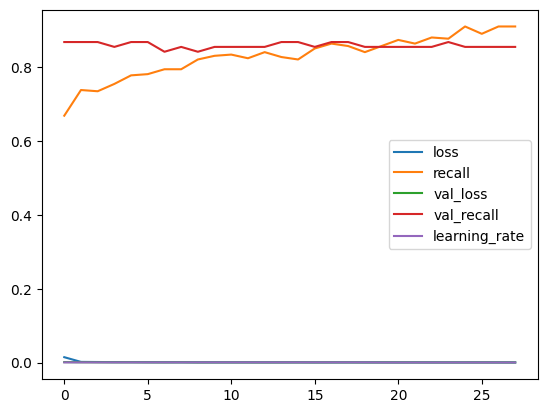

In [32]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [33]:
eval_metric(model, X_train, y_train, X_test, y_test)

5675/5675 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Test_Set
[[56640    11]
 [   22    73]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.87      0.77      0.82        95

    accuracy                           1.00     56746
   macro avg       0.93      0.88      0.91     56746
weighted avg       1.00      1.00      1.00     56746


Train_Set
[[181220     62]
 [    51    251]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    181282
           1       0.80      0.83      0.82       302

    accuracy                           1.00    181584
   macro avg       0.90      0.92      0.91    181584
weighted avg       1.00      1.00      1.00    181584



1774/1774 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


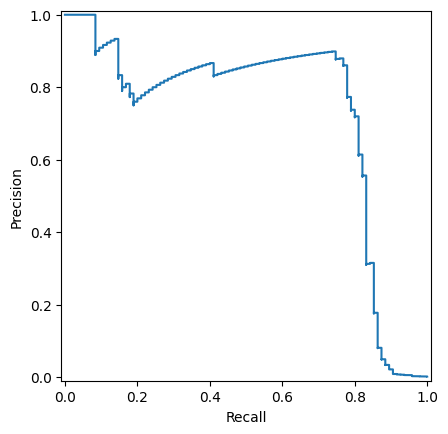

In [45]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

y_scores = model.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot();

### Model 2 With Unbalanced Data Techniques

In [37]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [38]:
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=0.2)

resampling = Pipeline([('over', over), ('under', under)])
X_train_res, y_train_res = resampling.fit_resample(X_train, y_train)

In [39]:
model2 = create_ann()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

history = model2.fit(X_train_res, y_train_res,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr],
                    class_weight=class_weight_dict,
                    verbose=1)

Epoch 1/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 1.1716 - recall: 0.8515 - val_loss: 0.0019 - val_recall: 0.8816 - learning_rate: 5.0000e-04
Epoch 2/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.3346 - recall: 0.8956 - val_loss: 0.0016 - val_recall: 0.8816 - learning_rate: 5.0000e-04
Epoch 3/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2211 - recall: 0.9299 - val_loss: 0.0012 - val_recall: 0.8816 - learning_rate: 5.0000e-04
Epoch 4/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1655 - recall: 0.9518 - val_loss: 0.0010 - val_recall: 0.8816 - learning_rate: 5.0000e-04
Epoch 5/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1227 - recall: 0.9687 - val_loss: 9.0272e-04 - val_recall: 0.8947 - learning_rate: 5.0000e-04
Epoch 6/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1175 - recall: 0.9736 - val_loss: 8.3571e-04 - val_recall: 0.8684 - learning_rate: 5.0000e-04
Epoch 7/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0892 - recall: 

<Axes: >

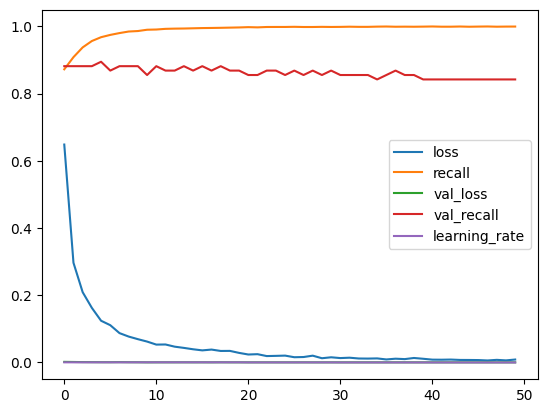

In [40]:
loss_df = pd.DataFrame(model2.history.history)
loss_df.plot()

In [42]:
eval_metric(model2, X_train_res, y_train_res, X_test, y_test)

1700/1700 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Test_Set
[[56625    26]
 [   19    76]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.75      0.80      0.77        95

    accuracy                           1.00     56746
   macro avg       0.87      0.90      0.89     56746
weighted avg       1.00      1.00      1.00     56746


Train_Set
[[45308    12]
 [    0  9064]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45320
           1       1.00      1.00      1.00      9064

    accuracy                           1.00     54384
   macro avg       1.00      1.00      1.00     54384
weighted avg       1.00      1.00      1.00     54384



1774/1774 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


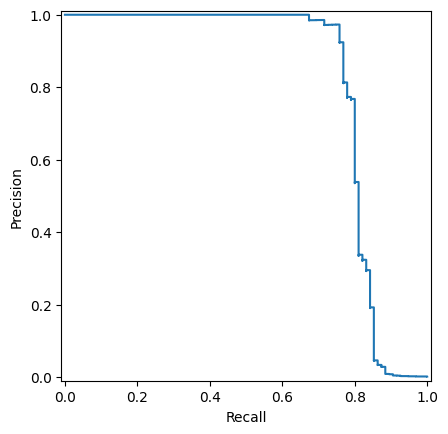

In [44]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

y_scores = model2.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot();


### Final takeaways:
- Although ANN model may perform equally strong or even better than Machine Learning models, training and obtaining predictions from Deep Learning models are costly.
- Over- or under-sampling the training data should be further analyzed. With a good blend of resampling, test scores would be much better.